In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization import *
from torch.nn import functional as F
import pandas as pd

In [2]:
def sample(d):
    return torch.concat((torch.rand(d), torch.ones(1)))

def ridge_reg(dataset, actions, rewards, lmbda=1.0, alpha=0.01):
    # lambda is regularization param, alpha is param for stdev
    n, d = dataset.shape
    _, m = actions.shape
    assert len(actions) == n
    assert len(rewards) == n
    sum_r_x = torch.zeros((m, d))
    sum_x_x = torch.zeros(m)
    for t in range(n):
        a = torch.argmax(actions[t]).item()
        sum_r_x[a] += rewards[t] * dataset[t]
        sum_x_x[a] += dataset[t] @ dataset[t]
    # print(sum_r_x, sum_x_x)
    phi = (sum_r_x + alpha * torch.sqrt(lmbda + sum_x_x.reshape(m, 1))) / (lmbda + sum_x_x.reshape(m, 1))
    return phi

def ridge_reg(dataset, actions, rewards, lmbda=1.0, alpha=1.0):
    # lambda is regularization param, alpha is param for stdev
    n, d = dataset.shape
    _, m = actions.shape
    assert len(actions) == n
    assert len(rewards) == n
    action_indexes = {}
    for a in range(m):
        action_indexes[a] = []
    for t in range(n):
        a = torch.argmax(actions[t]).item()
        action_indexes[a].append(t)
    phi = torch.zeros((d, m))
    for a in range(m):
        i = action_indexes[a]
        dataset_i = dataset[i]
        rewards_i = rewards[i]
        xtx = dataset_i.T @ dataset_i + lmbda * torch.eye(d)
        xtr = dataset_i.T @ rewards_i
        phi[:,a] = torch.linalg.pinv(xtx) @ xtr
        phi[:,a] += alpha * np.sqrt(np.log(n+1) / (len(i)+1)) # UCB exploration term
    return phi.T # want m x d output

In [3]:
agent_iters = 500
temperature = 0.02
adversarial = False

In [4]:
alpha = 1.0
lmbda = 1.0

In [ ]:
m = 2
d = 2
# u = torch.tensor([0.1, 0.1, 0.15])
u = torch.tensor([0.1, 0.2])
phi_opt = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
# phi_opt = torch.tensor([[1, 0, 0.25], [0, 1, 0.25], [0.8, 0.8, 0.]], dtype=torch.float32)
W = phi_opt.T
dataset_list = []
aug_list = []
reward_list = []
action_list = []
phi = torch.rand((m, d + 1))
x = sample(d)
x_hat = gragent(x, phi, u, attempts=1, iters=agent_iters, temp=temperature) if adversarial else x.clone()
dataset_list.append(x)
aug_list.append(x_hat)
dataset = torch.stack(dataset_list)
augs = torch.stack(aug_list)
reward_list.append(dm_reward(x @ W, x_hat, phi, temp=temperature))
rewards = torch.stack(reward_list)
action_list.append(F.one_hot(torch.argmax(classify(x=x_hat, phi=phi, temp=temperature)), num_classes=m))
actions = torch.stack(action_list)
optimal_reward_list = [dm_reward(x @ W, x, phi_opt, temp=temperature)]
random_reward_list = [dm_reward(x @ W, x_hat, torch.rand((m, d + 1)), temp=temperature)]

In [ ]:
for _ in range(0):
    phi = torch.rand((m, d+1))
    x = sample(d)
    x_hat = gragent(x, phi, u, attempts=1, iters=agent_iters, temp=temperature) if adversarial else x.clone()
    dataset_list.append(x)
    aug_list.append(x_hat)
    dataset = torch.stack(dataset_list)
    augs = torch.stack(aug_list)
    reward_list.append(dm_reward(x @ W, x_hat, phi, temp=temperature))
    rewards = torch.stack(reward_list)
    action_list.append(F.one_hot(torch.argmax(classify(x=x_hat, phi=phi, temp=temperature)), num_classes=m))
    actions = torch.stack(action_list)
    optimal_reward_list.append(dm_reward(x @ W, x, phi_opt, temp=temperature))
    
for _ in tqdm(range(1000), position=0, leave=True):
    phi = ridge_reg(augs, actions, rewards, alpha=alpha, lmbda=lmbda)
    x = sample(d)
    x_hat = gragent(x, phi, u, attempts=1, iters=agent_iters, temp=temperature) if adversarial else x.clone()
    dataset_list.append(x)
    aug_list.append(x_hat)
    dataset = torch.stack(dataset_list)
    augs = torch.stack(aug_list)
    reward_list.append(dm_reward(x @ W, x_hat, phi, temp=temperature))
    rewards = torch.stack(reward_list)
    action_list.append(F.one_hot(torch.argmax(classify(x=x_hat, phi=phi, temp=temperature)), num_classes=m))
    actions = torch.stack(action_list)
    optimal_reward_list.append(dm_reward(x @ W, x, phi_opt, temp=temperature))
    random_reward_list.append(dm_reward(x @ W, x_hat, torch.rand((m, d + 1)), temp=temperature))

    # n = len(preds)
    # print('Random:   ', rand_cum_dm_reward.item() / n, rand_new_dm_reward.item())
    # print('Predicted:', cum_dm_reward.item() / n, new_dm_reward.item())
    # print('Optimal:  ', opt_cum_dm_reward.item() / n, opt_new_dm_reward.item())

In [ ]:
# def ridge_reg_linucb(dataset, actions, rewards, lmbda=1.0, alpha=2.358, temp=0.02):
#     # lambda is regularization param, alpha is param for stdev
#     n, d = dataset.shape
#     _, m = actions.shape
#     assert len(actions) == n
#     assert len(rewards) == n
#     action_indexes = {}
#     for a in range(m):
#         action_indexes[a] = []
#     for t in range(n):
#         a = torch.argmax(actions[t]).item()
#         action_indexes[a].append(t)
#     phiT = torch.zeros((d, m))
#     classifiers = []
#     for a in range(m):
#         i = action_indexes[a]
#         dataset_i = dataset[i]
#         rewards_i = rewards[i]
#         xtx = dataset_i.T @ dataset_i
#         xtr = dataset_i.T @ rewards_i
#         phiT[:,a] = torch.linalg.pinv(xtx) @ xtr
#         clf = lambda x : phiT[:,a].T @ x + alpha * torch.sqrt(x.T @ torch.linalg.pinv(xtx) @ x)
#         classifiers.append(clf)
#     return lambda x : softmax(torch.stack([clf(x) for clf in classifiers]), temp=temp)

# def dm_reward_linucb(xWs, x_hat, clf, temp=0.02):
#     return xWs @ clf(x_hat)

# for _ in tqdm(range(1000), position=0, leave=True):
#     phi = ridge_reg_linucb(augs, actions, rewards, alpha=2.358, lmbda=0)
#     # phi = torch.rand((m, d+1))
#     x = sample(d)
#     x_hat = x.clone()
#     dataset_list.append(x)
#     aug_list.append(x_hat)
#     dataset = torch.stack(dataset_list)
#     augs = torch.stack(aug_list)
#     reward_list.append(dm_reward_linucb(x @ W, x_hat, phi))
#     rewards = torch.stack(reward_list)
#     action_list.append(F.one_hot(torch.argmax(phi(x_hat)), num_classes=m))
#     actions = torch.stack(action_list)

#     # n = len(preds)
#     # print('Random:   ', rand_cum_dm_reward.item() / n, rand_new_dm_reward.item())
#     # print('Predicted:', cum_dm_reward.item() / n, new_dm_reward.item())
#     # print('Optimal:  ', opt_cum_dm_reward.item() / n, opt_new_dm_reward.item())

# fig, (p1, p2) = plt.subplots(1, 2)
# preds = [torch.argmax(phi(x)).item() for x in augs]
# p1.scatter(dataset[:,0], dataset[:,1], c=preds)
# lbls = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi_opt, temp=temperature).T]
# p2.scatter(dataset[:,0], dataset[:,1], c=lbls)
# p1.set_aspect('equal', 'box')
# p2.set_aspect('equal', 'box')

In [ ]:
fig, (p1, p2) = plt.subplots(1, 2)
preds = [torch.argmax(a).item() for a in classify(x=augs, phi=phi, temp=temperature).T]
p1.scatter(dataset[:,0], dataset[:,1], c=preds)
lbls = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi_opt, temp=temperature).T]
p2.scatter(dataset[:,0], dataset[:,1], c=lbls)
p1.set_aspect('equal', 'box')
p2.set_aspect('equal', 'box')

In [ ]:
phi, phi_opt

In [ ]:
diff_df = pd.DataFrame((torch.stack(optimal_reward_list) - torch.stack(reward_list)).numpy())
diff_df.describe()

In [5]:
alpha = 0.0
lmbda = 0.0

In [6]:
m = 2
d = 2
# u = torch.tensor([0.1, 0.1, 0.15])
u = torch.tensor([0.1, 0.2])
phi_opt = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
# phi_opt = torch.tensor([[1, 0, 0.25], [0, 1, 0.25], [0.8, 0.8, 0.]], dtype=torch.float32)
W = phi_opt.T
# phi = torch.rand((m, d + 1))
phi = torch.tensor([[1., 0., 0.], [0., 1., 0.]], dtype=torch.float32)
dataset_list = [sample(d) for _ in range(100)]
aug_list = [gragent(x, phi, u, attempts=1, iters=agent_iters, temp=temperature) for x in dataset_list]
dataset = torch.stack(dataset_list)
augs = torch.stack(aug_list)
reward_list = [dm_reward(x @ W, x_hat, phi, temp=temperature) for x, x_hat in zip(dataset_list, aug_list)]
action_list = [F.one_hot(torch.argmax(classify(x=x_hat, phi=phi, temp=temperature)), num_classes=m) for x_hat in aug_list]
rewards = torch.stack(reward_list)
actions = torch.stack(action_list)

C:\Users\Alex\Desktop\academics\strat-bandits\strategic-bandits\optimization.py:93: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2318.)
  return softmax( phi @ x.T , temp=temp)


In [7]:
for _ in tqdm(range(20), position=0, leave=True):
    phi = ridge_reg(augs, actions, rewards, alpha=alpha, lmbda=lmbda)
    aug_list = [gragent(x, phi, u, attempts=1, iters=agent_iters, temp=temperature) for x in dataset_list]
    augs = torch.stack(aug_list)
    reward_list = [dm_reward(x @ W, x_hat, phi, temp=temperature) for x, x_hat in zip(dataset_list, aug_list)]
    action_list = [F.one_hot(torch.argmax(classify(x=x_hat, phi=phi, temp=temperature)), num_classes=m) for x_hat in aug_list]
    rewards = torch.stack(reward_list)
    actions = torch.stack(action_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:36<00:00, 37.85s/it]


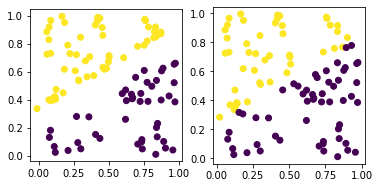

In [8]:
fig, (p1, p2) = plt.subplots(1, 2)
preds = [torch.argmax(a).item() for a in classify(x=augs, phi=phi, temp=temperature).T]
p1.scatter(augs[:,0], augs[:,1], c=preds)
lbls = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi_opt, temp=temperature).T]
p2.scatter(dataset[:,0], dataset[:,1], c=lbls)
p1.set_aspect('equal', 'box')
p2.set_aspect('equal', 'box')

In [9]:
phi, phi_opt

(tensor([[ 0.9992,  0.0012,  0.2003],
         [ 0.3925,  0.9823, -0.0618]]),
 tensor([[1.0000, 0.0000, 0.2000],
         [0.4472, 0.8944, 0.0000]]))

In [ ]:
augs_opt = torch.stack([gragent(x, phi_opt, u, attempts=1, iters=agent_iters, temp=temperature) for x in dataset_list])

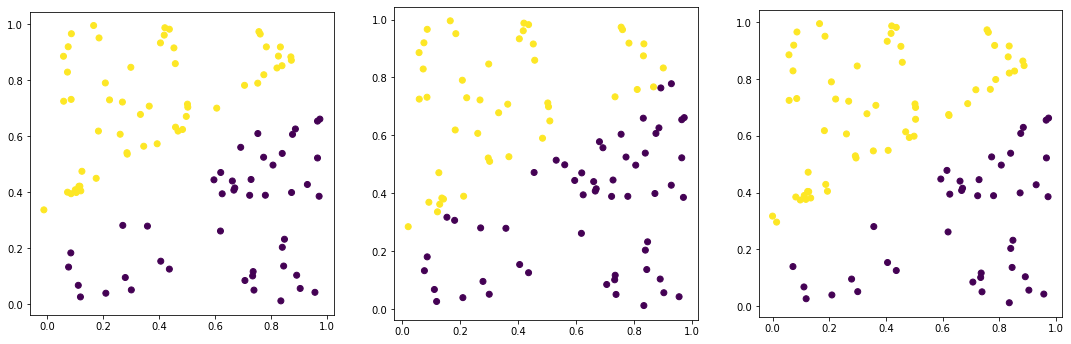

In [11]:
fig, (p1, p2, p3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
preds = [torch.argmax(a).item() for a in classify(x=augs, phi=phi, temp=temperature).T]
p1.scatter(augs[:,0], augs[:,1], c=preds)
lbls = [torch.argmax(a).item() for a in classify(x=dataset, phi=phi_opt, temp=temperature).T]
p2.scatter(dataset[:,0], dataset[:,1], c=lbls)
lbls = [torch.argmax(a).item() for a in classify(x=augs_opt, phi=phi_opt, temp=temperature).T]
p3.scatter(augs_opt[:,0], augs_opt[:,1], c=lbls)
p1.set_aspect('equal', 'box')
p2.set_aspect('equal', 'box')
p3.set_aspect('equal', 'box')